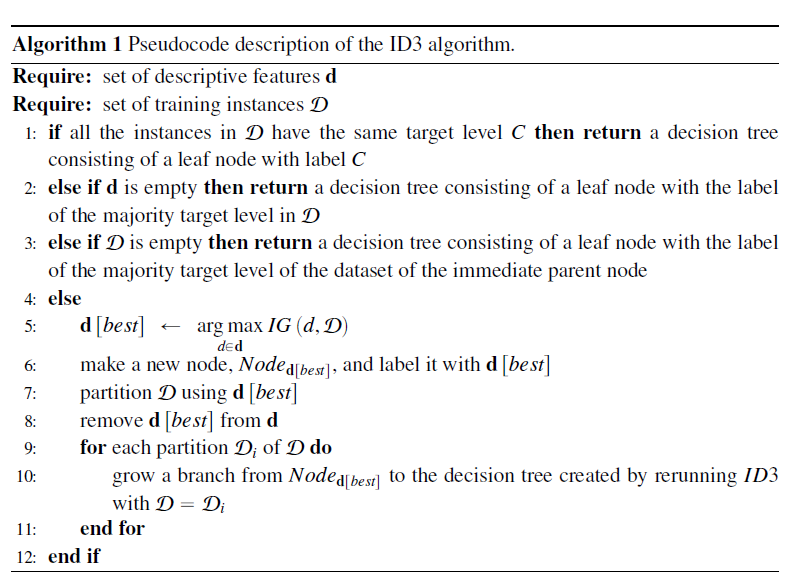

In [88]:
import pandas as pd
import numpy as np

tennis_df = pd.read_csv("assets/playtennis_dayremoved.csv")
census_df = pd.read_csv("assets/census_training.csv")
emails_df = pd.read_csv("assets/emails_noID.csv")

print(tennis_df)
print(emails_df)

def getEntropy(df):
    # To make this function generic, get the class label
    className = df.keys()[-1]
    # Initialize entropy to 0
    entropy = 0
    # Gather unique values of class (yes, no, >50k, <=50k, etc)
    targetVariables = df[className].unique()
    # For each unique value
    for attr in targetVariables:
        # Number of 'attr'/total number of rows
        proportion = df[className].value_counts()[attr]/len(df[className])
        # Add -(fraction)log2(fraction)
        entropy += -proportion*np.log2(proportion)
    return entropy

def getInfoGain (df, attr):
    # To make this function generic, get the class label
    className = df.keys()[-1]
    # targetVariables are the yes/no or >50k/<=50k values
    targetVariables = df[className].unique()

    # Subset of the dataframe with 'Yes' values
    subset0 = df.where(df[className] == targetVariables[0]).dropna()
    # Subset of the dataframe with 'No' values
    subset1 = df.where(df[className] == targetVariables[1]).dropna()

    # Number of true values
    true = len(subset0.index)
    # Number of false values
    false = len(subset1.index)
    # Total rows
    total = true + false

    # Keeping track of the entropy summation
    summation = 0
    # For each unique value in the 'attr' column in the dataframe
    for value in df[attr].unique():
        entropy = 0
        # Number of 'yes' values matching the 'value' level of 'attr'
        num1 = len(subset0[attr].where(subset0[attr] == value).dropna())
        # Number of 'no' values matching the 'value' level of 'attr'
        num2 = len(subset1[attr].where(subset1[attr] == value).dropna())
        # Total number of 'value' levels of 'attr'
        denom = df[attr].value_counts()[value]

        # If statement to filter out zero value numerators (not compatible with log2)
        if num1 == 0:
            trueEntropy = 0
        else:
            # Entropy representing the true values in the 'attr' column
            trueEntropy = (num1/denom)*np.log2(num1/denom)
        # If statement to filter out zero value numerators (not compatible with log2)
        if num2 == 0:
            falseEntropy = 0
        else:
            # Entropy representing the false values in the 'attr' column
            falseEntropy = (num2/denom)*np.log2(num2/denom)
        # Subtract the two entropy values
        entropy -= trueEntropy
        entropy -= falseEntropy
        # Multiply by true or false over total and multiply by entropy, then add to summation.
        summation += (denom / total) * entropy

    # Information gain
    return getEntropy(df)-summation


# Returns the best feature in a particular dataset or partition of a data set
# for partitioning, based on information gain.
def bestFeature(df, features):
    infoGain = {}
    current = 0
    maximum = 0
    maxAttr = ""
    for attr in features:
        # infoGain.append(getInfoGain(df,attr))
        current = getInfoGain(df, attr)
        infoGain[current] = attr
        if current > maximum:
            maximum = current
            maxAttr = attr
    if current == maximum:
        best = features[0]
        return best
    # keys = infoGain.keys()
    # keys = list(map(float, keys))
    # # maximum = np.argmax(keys)
    # best = infoGain[maximum]
    # best = features[np.argmax(infoGain)]
    return maxAttr

def mostCommonValue(df, className):
    targetValues = pd.value_counts(df[className].values.ravel())
    index = targetValues.index
    
    mostCommon = index[0]
    count = 0
    maxIndex = 0
    for val in targetValues:
        if val > count:
            count = val
            mostCommon = index[maxIndex]
        maxIndex += 1
    return mostCommon

def buildTree(df, features, parentNode):
    # Get the target class name
    className = df.keys()[-1]
    
    # targetValues is a series containing each target level and their associated quantities
    targetValues = pd.value_counts(df[className].values.ravel())
    # index is the labels within target values (yes or no)
    index = targetValues.index
    
    # Length of the dataset
    rows = len(df)
#     rows = df.shape[0]
    
    # Base cases:
    if index.size == 1:
        # All remaining instances in the partition have the same value (yes or no)
        # We reached the end of this tree branch. This becomes a leaf node with the class value
        return index[0]
    elif df.empty:
        # For a particular partition, there are no instances that have a feature value
        # Return the most common class value of the dataset of the parent node
        mostCommon = mostCommonValue(parentNode, className)
        return mostCommon
    elif len(features) == 0:
        # All features along this path have been tested (no more features to split on)
        mostCommon = mostCommonValue(df, className)
        return mostCommon
# TREE PRUNING:
#     elif rows <= 30:
#         # This is tree pruning
#         mostCommon = mostCommonValue(df, className)
#         return mostCommon
    else:
        # Recursive case:
        # Get the best feature for splitting the data set using information gain
        best = bestFeature(df, features)

        # Create a root node of this section of the tree using best feature.
        root = {best : {}}
    
        # Remove best from the list of features
        features = [i for i in features if i != best]
        
        # Get unique values of the best feature
        uniqueValues = df[best].unique()
        
        # Build the tree by 
        for val in uniqueValues:
            parent = df.copy()
            
            # Create a partition
            indexBool = df[best] == val
            partition = df[indexBool]
            
            subtree = buildTree(partition, features, parent)
            root[best][val] = subtree
        
        return root




print(getInfoGain(tennis_df,'Outlook'))
print(getInfoGain(tennis_df,'Temperature'))
print(getInfoGain(tennis_df,'Humidity'))
print(getInfoGain(tennis_df,'Wind'))

# print(bestFeature(tennis_df))

# t = buildTree(tennis_df)
# print(t)

# import pprint

# pprint.pprint(t)

print()
# split = split(tennis_df, bestFeature(tennis_df),'Rain')
# print(split)
# print(np.unique(split['PlayTennis'], return_counts=True))
className = census_df.keys()[-1]
targetValues = pd.value_counts(census_df[className].values.ravel())
seriesIndex = targetValues.index

print(targetValues)
print()
print(seriesIndex)
print()
# print(mostCommonValue(tennis_df, 'PlayTennis'))

# attributes = tennis_df.keys()[:-1]
# parentNode = None
# t = buildTree(tennis_df, attributes, parentNode)
# print(t)

# print()
# emailAttr = emails_df.keys()[:-1]
# parentNodeEmails = None
# emailTree = buildTree(emails_df, emailAttr, parentNodeEmails)
# print(emailTree)

# print(bestFeature(census_df))

# census_df = pd.read_csv("assets/census_training.csv")

# print()
censusAttr = census_df.keys()[:-1]
parentNodeCensus = None
censusTree = buildTree(census_df, censusAttr, parentNodeCensus)
# print(censusTree)

# tennisAttr = tennis_df.keys()[:-1]
# parentNodeTennis = None
# tennisTree = buildTree(tennis_df, tennisAttr, parentNodeTennis)
# print(tennisTree)

print("Done")

     Outlook Temperature Humidity    Wind PlayTennis
0      Sunny         Hot     High    Weak         No
1      Sunny         Hot     High  Strong         No
2   Overcast         Hot     High    Weak        Yes
3       Rain        Mild     High    Weak        Yes
4       Rain        Cool   Normal    Weak        Yes
5       Rain        Cool   Normal  Strong         No
6   Overcast        Cool   Normal  Strong        Yes
7      Sunny        Mild     High    Weak         No
8      Sunny        Cool   Normal    Weak        Yes
9       Rain        Mild   Normal    Weak        Yes
10     Sunny        Mild   Normal  Strong        Yes
11  Overcast        Mild     High  Strong        Yes
12  Overcast         Hot   Normal    Weak        Yes
13      Rain        Mild     High  Strong         No
   SUSPICIOUS WORDS  UNKNOWN SENDER  CONTAINS IMAGES CLASS
0              True           False             True  spam
1              True            True            False  spam
2              True         

In [81]:
from graphviz import Digraph

def draw_decision_tree_dictionary(tree_dictionary):
    if not isinstance(tree_dictionary, dict):
        raise TypeError("Argument tree_dictionary must be of type dictionary.")
    if not tree_dictionary:
        raise ValueError("Dictionary tree_dictionary is empty.")
        
    dot = Digraph(strict=True)
    draw_tree(dot, tree_dictionary, None)
    
    return dot

def draw_tree(dot, tree_dictionary, parent_node_name):
    if isinstance(tree_dictionary, dict):
        for key in tree_dictionary:
            no_spaces_key = str(key).replace(" ", "")
            
            dot.node(no_spaces_key, str(key), shape="ellipse")
            
            if parent_node_name != None:
                dot.edge(parent_node_name, no_spaces_key)
                
            draw_tree(dot,tree_dictionary[key], no_spaces_key)
    else:
        val = str(tree_dictionary)
        dot.node(val, val, shape="plaintext")
        dot.edge(parent_node_name, val)

In [60]:
dd = draw_decision_tree_dictionary(censusTree)

In [61]:
dd.render(filename='censustreeprune', view = True)

'censustreeprune.pdf'

In [82]:
def predict(tree, instance):
    if not isinstance(tree, dict): #if it is leaf node
        return tree #return the value
    else:
        root_node = next(iter(tree)) #getting first key/feature name of the dictionary
        feature_value = instance[root_node] #value of the feature
        if feature_value in tree[root_node]: #checking the feature value in current tree node
            return predict(tree[root_node][feature_value], instance) #goto next feature
        else:
            return None

query = {'age': 'age1', 'workclass':'Private','education':'college','education_num':'high-education',	
       'marital_status':'Married-civ-spouse','occupation':'Adm-clerical','relationship':'Husband','race':'White','sex':'Male','hours_per_week':'full-time','native_country':'United-States'}
instance = pd.Series(query)
print(predict(censusTree, instance))

def compareAgainst(df, tree):
    className = df.keys()[-1]
    rows = len(df)
    correct = 0
    for i in range(rows):
        rowClassValue = df.loc[i, className]
        prediction = predict(tree, df.loc[i])
        
        if rowClassValue == prediction:
            correct += 1
    
    accuracy = (correct/rows)*100
    print(str(accuracy) + "%")

>50K


In [89]:
census_test = pd.read_csv("assets/census_training_test.csv")



compareAgainst(census_test, censusTree)

75.05323396326857%


In [67]:
tennisDD = draw_decision_tree_dictionary(tennisTree)
tennisDD.render(filename = 'tennistree', view = True)

'tennistree.pdf'